# import the necessary packages

In [6]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Lambda
from tensorflow.keras.datasets import mnist
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.models import load_model

from kerastuner.tuners import RandomSearch
from kerastuner.engine.hyperparameters import HyperParameters
import time

import tensorflow as tf

from tensorflow.keras.preprocessing.sequence import pad_sequences

import tensorflow.keras.backend as K
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from encoder import *
from pairing import *


# Idea From 

[Siamese Convolutional Networks for Cognate Identification by Taraka Rama](https://aclanthology.org/C16-1097.pdf)

# Basic Architecture

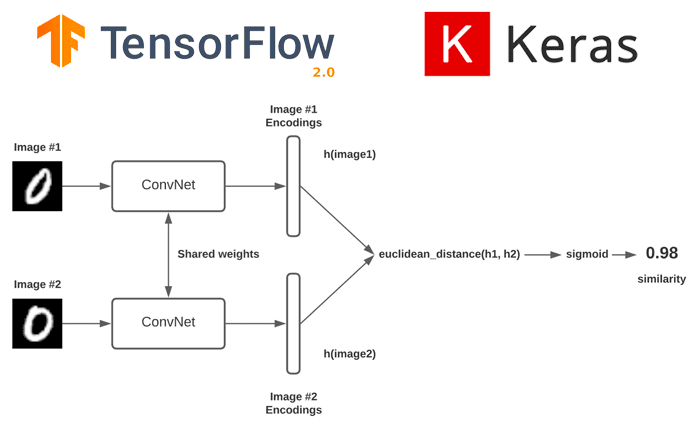

# Global Variables

In [7]:
import os
# specify the shape of the inputs for our network
IMG_SHAPE = (25, 25, 1)
# specify the batch size and number of epochs
BATCH_SIZE = 64
EPOCHS = 300
# define the path to the base output directory
BASE_OUTPUT = "output"
# use the base output path to derive the path to the serialized
# model along with training history plot
MODEL_PATH = os.path.sep.join([BASE_OUTPUT, "siamese_model"])
PLOT_PATH = os.path.sep.join([BASE_OUTPUT, "plot.png"])

LOG_DIR = f"{int(time.time())}"

In [8]:
class myCallback(Callback):
    def on_epoch_end(self,epoch,logs={}):
        if((logs.get('accuracy') > 0.9) and (logs.get('val_accuracy') > 0.74)):
            print("\n[INFO] Reached target accuracy so canceling training")
            self.model.stop_training = True

# Distance Function

In [9]:
def euclidean_distance(vectors):
	# unpack the vectors into separate lists
	(featsA, featsB) = vectors
	# compute the sum of squared distances between the vectors
	sumSquared = K.sum(K.square(featsA - featsB), axis=1,
		keepdims=True)
	# return the euclidean distance between the vectors
	return K.sqrt(K.maximum(sumSquared, K.epsilon()))

# Training Data

In [10]:
def plot_training(H, plotPath):
	# construct a plot that plots and saves the training history
	plt.style.use("ggplot")
	plt.figure()
	plt.plot(H.history["loss"], label="train_loss")
	plt.plot(H.history["val_loss"], label="val_loss")
	plt.plot(H.history["accuracy"], label="train_acc")
	plt.plot(H.history["val_accuracy"], label="val_acc")
	plt.title("Training Loss and Accuracy")
	plt.xlabel("Epoch #")
	plt.ylabel("Loss/Accuracy")
	plt.legend(loc="lower left")
    
	plt.show()
    

 # Load the necessarry data 

In [11]:
df = pd.read_excel("/Users/haroldsmith/Desktop/CognatePredictor/conjoined_hash_table.xlsx")


In [12]:
df["Phonological Cognate"] = df["Phonological Cognate"].fillna(value = -1)
df = df.fillna("Blank").sort_values(by = ["Phonological Cognate"], ascending = False)
df

,Primary ID,prac_rep,tech_rep,spanish,english,latin,source,Phonological Cognate,Cognates,Proto-Zapotecan,Same Referent,Looser comparison,PZap_gloss,BiblioRef,Cordova_ethnobot
60677,328590,hueroxo quijxi,hue+róxo quijxi,roçador tal. [roçar las yeruas con la mano],Blank,Blank,Cordova,20.0,quijxi,ki7xxi7,Blank,Blank,Blank,Blank,Yes
2049,69028,"kishe_& nyaka& kuanyo&""",kixe_&7 nyaka& kwanyo&,1 hierba oreja de cuan*o [TCR],Blank,Blank,Zenzontepec Chatino,20.0,kixe_&7,ki7xxi7,Blank,Blank,Blank,Blank,Blank
62810,330723,neza quijxi,nèza quijxi,senda assi escura no hollada y con yerua,Blank,Blank,Cordova,20.0,quijxi,ki7xxi7,Blank,Blank,Blank,Blank,Yes
2054,69033,"kishe_& su_te!& li!su_""",kixe_&7 su_te!&7 li!su_,1 canilla de zopilote [TCR],Blank,Blank,Zenzontepec Chatino,20.0,kixe_&7,ki7xxi7,Blank,Blank,Blank,Blank,Blank
2053,69032,"kishe_& su_te!& kusu_""",kixe_&7 su_te!&7 ku-su_7,1 canilla de viejo [TCR],1,Blank,Zenzontepec Chatino,20.0,kixe_&7,ki7xxi7,Blank,Blank,Blank,Blank,Blank
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23919,291832,toxigea,to+xige-a,desmenuzar pan o desmigajar,Blank,Blank,Cordova,-1.0,Blank,Blank,Blank,Blank,Blank,Blank,No
23920,291833,toxogea,to+xòge-a,desmenuzar pan o desmigajar,Blank,Blank,Cordova,-1.0,Blank,Blank,Blank,Blank,Blank,Blank,No
23921,291834,teogia,te+ògi-a,desmenuzado ser assi. [pan o desmigajar],Blank,Blank,Cordova,-1.0,Blank,Blank,Blank,Blank,Blank,Blank,No
23922,291835,tiogia,ti+ògi-a,desmenuzado ser assi. [pan o desmigajar],Blank,Blank,Cordova,-1.0,Blank,Blank,Blank,Blank,Blank,Blank,No


In [13]:
vals = np.arange(1,20,1)
df_no_label = df.loc[~df["Phonological Cognate"].isin(vals)]
located = df.loc[df["Phonological Cognate"].isin(vals)]
located = located.sample(located.shape[0])
located["Phonological Cognate"] = located["Phonological Cognate"].to_numpy() - 1

In [14]:
words_to_translate = df["tech_rep"].to_numpy()
associated_labels = df["Phonological Cognate"]
images = located["tech_rep"].to_numpy()
labels = located["Phonological Cognate"].to_numpy().astype(np.int32)


# EDA

In [15]:
df["tech_rep"].describe()

count     70866
unique    62606
top       Blank
freq        781
Name: tech_rep, dtype: object

In [16]:
df["source"].value_counts(0)

Cordova                      66978
San Juan Mixtepec Zapotec     1804
Diidxazá                      1062
Zenzontepec Chatino           1020
Blank                            2
Name: source, dtype: int64

In [17]:
df["length_tech_rep"] = df["tech_rep"].str.len()

df["length_tech_rep"].describe()

count    70866.000000
mean        15.769974
std          8.316909
min          1.000000
25%         10.000000
50%         14.000000
75%         20.000000
max        156.000000
Name: length_tech_rep, dtype: float64

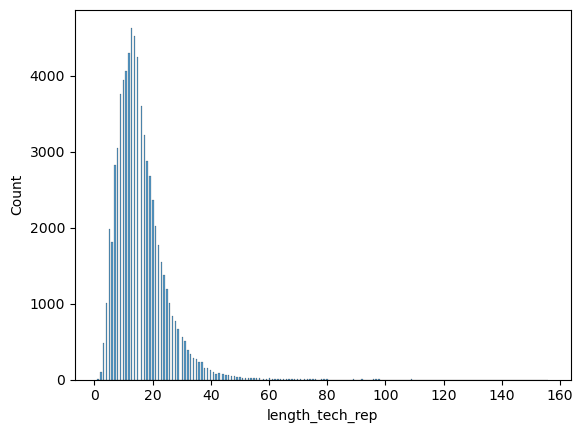

In [18]:
import seaborn as sns
sns.histplot(df["length_tech_rep"])
plt.show()

# Encoding Stage

In [19]:
encoding_table = pd.read_excel("/Users/haroldsmith/Desktop/CognatePredictor/Encoding_Table.xlsx").head(25).fillna(0)
encoding_table

,Features,A,B,C,D,E,F,I,L,M,...,ǒ,ǔ,nd,dx,ch,xh,zh,ny,kw,qu
0,Voiced/single/lenis,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
1,Labial,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,Dental,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Alveolar,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Palatal/Post-alveolar,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0
5,Velar,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
6,Uvular,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,Glottal,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,Stop,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
9,Fricative,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0


In [20]:

training_images = encoding(images)
words_to_translate = encoding(words_to_translate)



**********************
[INFO] ENCODING DATA
**********************


**********************
[INFO] ENCODING DATA
**********************



In [21]:
training_images.shape

(426, 25, 25)

# Example of how they are Encoded

Associated Word =  zhób-ngǎs


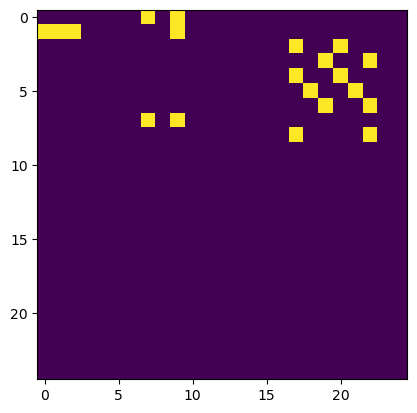

In [22]:
pairTrain, labelTrain = make_pairs(training_images,labels)
word_pairs, cognate = make_pairs(images, labels)
plt.figure()
plt.imshow(pairTrain[1,1])
print("Associated Word = ",word_pairs[1,1] )
plt.show()

In [23]:
def build_siamese_model(hp):
    # specify the inputs for the feature extractor network
    inputs = Input(IMG_SHAPE)
    # define the first set of CONV => RELU => POOL => DROPOUT layers
    x = Conv2D(hp.Int(
        'units 1',
        min_value=32,
        max_value=512,
        step=16,
        default=128), (2, 2), padding="same", activation="relu")(inputs)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(hp.Float(
                'dropout_1',
                min_value=0.0,
                max_value=0.5,
                default=0.25,
                step=0.05,
            ))(x)
    # second set of CONV => RELU => POOL => DROPOUT layers
    x = Conv2D(hp.Int(
        'units 2',
        min_value=32,
        max_value=512,
        step=32,
        default=128), (2, 2), padding="same", activation="relu")(x)
    x = MaxPooling2D(pool_size=2)(x)
    x = Dropout(hp.Float(
                'dropout_2',
                min_value=0.0,
                max_value=0.5,
                default=0.25,
                step=0.05,
            ))(x)
    # prepare the final outputs
    pooledOutput = GlobalAveragePooling2D()(x)
    outputs = Dense(hp.Float(
                'Embeding Dim',
                min_value=12,
                max_value=60,
                default=48,
                step=12,
            ))(pooledOutput)
    # build the model
    featureExtractor = Model(inputs, outputs)
    
    imgA = Input(shape = IMG_SHAPE)
    imgB = Input(shape = IMG_SHAPE)
    
    #print(featureExtractor)
    
    featsA = featureExtractor(imgA)
    featsB = featureExtractor(imgB)
    
    distance = Lambda(euclidean_distance)([featsA, featsB])
    outputs = Dense(1, activation= "sigmoid")(distance)
    model1 = Model(inputs=[imgA, imgB], outputs=outputs)
    #print(model1.summary())
    opt = tf.keras.optimizers.Adam(learning_rate=hp.Float(
                    'learning_rate',
                    min_value=1e-4,
                    max_value=1e-2,
                    sampling='LOG',
                    default=1e-3
                ))
    print("[INFO] compiling model...")
    model1.compile(loss="binary_crossentropy", optimizer= opt,
	metrics=["accuracy"])
    return model1
    # return the model to the calling function
   

In [24]:
callbacks = myCallback()

In [25]:

#hyperparameter tuning
tuner = RandomSearch(build_siamese_model,
                    objective = 'val_accuracy',
                    max_trials = 10,
                    executions_per_trial = 1,
                    directory = LOG_DIR)

tuner.search(x = [pairTrain[:, 0], pairTrain[:, 1]],
             y = labelTrain[:],
             epochs = 70,
             batch_size = 64,
             validation_split=(0.3) 
             
            )
            



[INFO] compiling model...

Search: Running Trial #1

Hyperparameter    |Value             |Best Value So Far 
units 1           |224               |?                 
dropout_1         |0.05              |?                 
units 2           |448               |?                 
dropout_2         |0.1               |?                 
Embeding Dim      |48                |?                 
learning_rate     |0.0040548         |?                 

[INFO] compiling model...
Epoch 1/70
10/10 [==============================] - 8s 769ms/step - loss: 0.6929 - accuracy: 0.5000 - val_loss: 0.6904 - val_accuracy: 0.5469
Epoch 2/70
10/10 [==============================] - 5s 524ms/step - loss: 0.6872 - accuracy: 0.5134 - val_loss: 0.6891 - val_accuracy: 0.5430
Epoch 3/70
10/10 [==============================] - 5s 482ms/step - loss: 0.6822 - accuracy: 0.5252 - val_loss: 0.6846 - val_accuracy: 0.5469
Epoch 4/70
10/10 [==============================] - 5s 500ms/step - loss: 0.6806 - accuracy: 0.

KeyboardInterrupt: 

# Best Model

In [26]:
print(tuner.get_best_hyperparameters()[0].values)
#print(tuner.results_summary())
#print(tuner.get_best_models()[0].summary())
tuned_param = tuner.get_best_hyperparameters()[0].values

tuned_param['units 1']

{'units 1': 400, 'dropout_1': 0.2, 'units 2': 480, 'dropout_2': 0.15000000000000002, 'Embeding Dim': 48.0, 'learning_rate': 0.000891368139372892}


400

# Optimized Model

In [27]:
def build_siamese_model():
    # specify the inputs for the feature extractor network
    inputs = Input(IMG_SHAPE)
    # define the first set of CONV => RELU => POOL => DROPOUT layers
    x = Conv2D(tuned_param['units 1'], (2, 2), padding="same", activation="relu")(inputs)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(tuned_param['dropout_1'])(x)
    # second set of CONV => RELU => POOL => DROPOUT layers
    x = Conv2D(tuned_param['units 2'], (2, 2), padding="same", activation="relu")(x)
    x = MaxPooling2D(pool_size=2)(x)
    x = Dropout(tuned_param['dropout_2'])(x)
    # prepare the final outputs
    pooledOutput = GlobalAveragePooling2D()(x)
    outputs = Dense(tuned_param['Embeding Dim'])(pooledOutput)
    # build the model
    featureExtractor = Model(inputs, outputs)
    
    imgA = Input(shape = IMG_SHAPE)
    imgB = Input(shape = IMG_SHAPE)
    
    #print(featureExtractor)
    
    featsA = featureExtractor(imgA)
    featsB = featureExtractor(imgB)
    
    distance = Lambda(euclidean_distance)([featsA, featsB])
    outputs = Dense(1, activation= "sigmoid")(distance)
    model1 = Model(inputs=[imgA, imgB], outputs=outputs)
    #print(model1.summary())
    opt = tf.keras.optimizers.Adam(learning_rate=tuned_param['learning_rate'])
    print("[INFO] compiling model...")
    model1.compile(loss="binary_crossentropy", optimizer= opt,
	metrics=["accuracy"])
    return model1

In [28]:
callbacks = myCallback()
model = build_siamese_model()
model.summary()

[INFO] compiling model...
Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 25, 25, 1)]  0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            [(None, 25, 25, 1)]  0                                            
__________________________________________________________________________________________________
model_2 (Functional)            (None, 48)           793568      input_5[0][0]                    
                                                                 input_6[0][0]                    
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 1)            0           m

# Prediction & Fitting


In [29]:

history = model.fit(
	[pairTrain[:, 0], pairTrain[:, 1]], labelTrain[:],
	validation_split=(0.2),
	batch_size= BATCH_SIZE, 
	epochs= 100,
    callbacks = callbacks)
    # serialize the model to disk<br>
print("[INFO] saving siamese model...")
model.save(MODEL_PATH)
# plot the training history<br>



Epoch 1/100
11/11 [==============================] - 20s 1s/step - loss: 0.6918 - accuracy: 0.4993 - val_loss: 0.6870 - val_accuracy: 0.5263
Epoch 2/100
11/11 [==============================] - 16s 1s/step - loss: 0.6893 - accuracy: 0.4993 - val_loss: 0.6872 - val_accuracy: 0.5263
Epoch 3/100
11/11 [==============================] - 12s 1s/step - loss: 0.6856 - accuracy: 0.4993 - val_loss: 0.6848 - val_accuracy: 0.5263
Epoch 4/100
11/11 [==============================] - 16s 1s/step - loss: 0.6828 - accuracy: 0.4993 - val_loss: 0.6822 - val_accuracy: 0.5322
Epoch 5/100
11/11 [==============================] - 12s 1s/step - loss: 0.6803 - accuracy: 0.5051 - val_loss: 0.6806 - val_accuracy: 0.5439
Epoch 6/100
11/11 [==============================] - 10s 908ms/step - loss: 0.6789 - accuracy: 0.5066 - val_loss: 0.6789 - val_accuracy: 0.5614
Epoch 7/100
11/11 [==============================] - 16s 2s/step - loss: 0.6746 - accuracy: 0.5140 - val_loss: 0.6769 - val_accuracy: 0.5556
Epoch 8/10

[INFO] plotting training history...


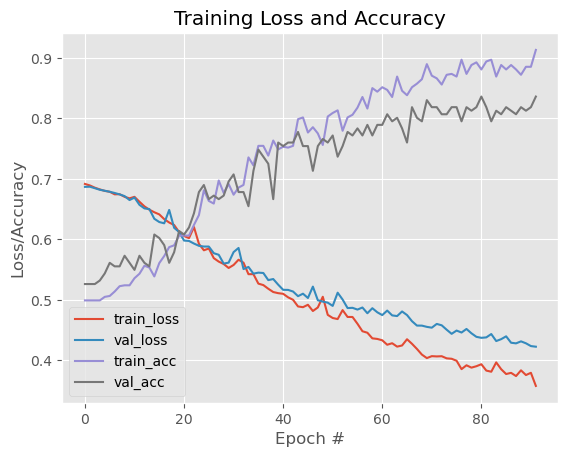

In [30]:
print("[INFO] plotting training history...")
plot_training(history, PLOT_PATH)

In [37]:



test_labels = associated_labels[0:1]
test_pred_images = encoding(test_prediction_words)

plt.figure()

plt.imshow(test_pred_images[0])

model = load_model(MODEL_PATH)

test_prediction_words = words_to_translate
test_pred_images = encoding(test_prediction_words)
test_prediction_words_endcode = np.expand_dims(encoding(test_prediction_words),axis = -1)
predict_train = np.expand_dims(test,axis = -1)



In [43]:
len(test_prediction_words_endcode)

70866

In [46]:
pairs = []
for i in range(len(test_prediction_words_endcode)):
    pairs.append([test_prediction_words_endcode[0],test_prediction_words_endcode[i]])
    

pairs = np.array(pairs)


In [72]:
pairs.shape

(70866, 2, 25, 25, 1)

In [48]:
prediction = model.predict([pairs[:, 0], pairs[:, 1]])


In [55]:
cognate_index = []
for i in range(len(prediction)):
    if(prediction[i] > 0.82):
        cognate_index.append(i)

In [60]:
words_to_translate[np.argmax(prediction)]

'cica-lo+huáa-le çàca nócha'

In [62]:
min(prediction)

array([0.00251958], dtype=float32)

In [64]:
words_to_translate[0]

'hue+róxo quijxi'

In [65]:
words_to_translate[np.argmax(prediction)]

'hue+róxo quijxi'

In [71]:
test1 = encoding(words_to_translate[0])
test2 = encoding(words_to_translate[np.argmax(prediction)])

np.expand_dims(test1,axis = -1).shape

(15, 25, 25, 1)